# RTED-TDS Co-Sim

Test parameters of AGC when there is EV2 but no EVA.

## Import case

In [1]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import andes
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost
andes.config_logger(stream_level=20)

import pandapower as pp

from jams import rted2, rted3

from ev_ssm import ev_ssm

print(andes.__version__)
print(pp.__version__)

caseH = 18

# --- ANDES case ---
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ssa.TDS.config.save_mode = 'manual'
ssa.TDS.config.no_tqdm = 1

# Set load as constant load.
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ssa.config.numba = 1


Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


0.post4486.dev0+gb285a56
2.8.0
Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1728 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0662 seconds.
System internal structure set up in 0.0245 seconds.


ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

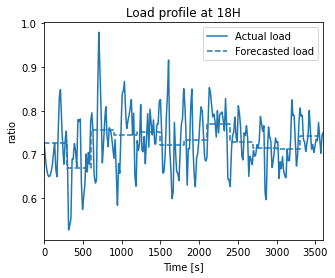

In [2]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

# the coefficient can be adjusted to fit the case
if caseH == 10:
    d_syn['sload'] = 0.8*(d_syn['ha10'] - d_syn['ha10'].min()) / d_syn['ha10'].min() + 0.7
if caseH == 18:
    d_syn['sload'] = 0.8*(d_syn['ha18'] - d_syn['ha18'].min()) / d_syn['ha18'].min() + 0.7

# extensify load fluctuation
avg = d_syn['sload'].rolling(70).mean()
fluc = 30
d_syn['sload'] = fluc * (d_syn['sload'] - avg) + avg

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# align starting point of load with starting point of dispatch results
d_syn['sload'][0] = d_exp['sload'].iloc[0]
d_syn['sload'][1:100] = None
d_syn['sload'] = d_syn['sload'].interpolate(method='polynomial', order=3)

# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['sload'], color='tab:blue', linestyle='-')
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')


## Setup ``ssp`` and ``ssd``

In [3]:
# --- set up EV generator data ---
ev_idx = 'PV_10'
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=30 / ssa.config.mva)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=999 / ssa.config.mva)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=-999 / ssa.config.mva)

# --- setup pandapower: ssp ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, unit: $/MWh; G1-11. G10 EV, G11 Slack; 
# set EV as -10, for the cost of SFR mileage
c1 = [20, 20, 20, 20, 20, 20, 20, 20, 20, -10, 20]
c0 = [500, 380, 42, 380, 295, 400, 350, 330, 490, 0000, 550]
c2 = [0.014, 0.020, 0.194, 0.020, 0.0255, 0.0210, 0.230, 0.0222, 0.0150, 0.000, 0.0300]
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 4] = np.array(c2) / ssa.config.mva
gen_cost[:, 5] = np.array(c1) / ssa.config.mva
gen_cost[:, 6] = np.array(c0) / ssa.config.mva

add_gencost(ssp, gen_cost)

# --- setup RTED: ssd ---
ssd = rted3(name='RTED', OutputFlag=0)
ssd.from_andes(ssa)
ssd.build()

# set EV generator as uncontrollable
ssd.gen.ctrl.loc[ev_idx] = 0

# set EV geenrator as type2
prumax = 0
prdmax = 0
ssd.def_type2([ev_idx], [prumax], [prdmax])

# Case data comes from a MPCE
# https://ieeexplore.ieee.org/document/9018441
# set ramp_5
ramp_15 = [156, 120, 130, 110, 80, 105, 90, 90, 150, 999, 200]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen['ramp_5'] = np.array(ramp_15) / 3 / ssd.mva

# set cost
ssd.cost['c1'] = c1
ssd.cost['c2'] = c2
ssd.cost['c0'] = c0

# adjust SFR cost of EV lower than SynGen
ssd.cost['cru'] = [0] * ssd.gen.shape[0]
ssd.cost['cru'].loc[ev_idx] = -1
ssd.cost['crd'] = ssd.cost.cru

# --- benchmark ssd with ssp using DCOPF ---
pp.rundcopp(ssp)
dc_comp = ssp.res_gen.copy()
gb_res = ssd.solve(disable_sfr=True, disable_ramp=True, info=False)
dc_comp['p_mw(GB)'] = ssd.mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0843 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916036148
2: |F(x)| = 0.1313532503
3: |F(x)| = 0.0003431212806
4: |F(x)| = 4.183613456e-09
Converged in 5 iterations in 0.0040 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0037 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916036148
2: |F(x)| = 0.1313532503
3: |F(x)| = 0.0003431212806
4: |F(x)| = 4.183613456e-09
Converged in 5 iterations in 0.0048 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


In [4]:
dc_comp

,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.031255,94.845507,15.883073,1.0,970.031250
1,645.999994,311.543380,2.228140,1.0,646.000000
2,290.000000,149.404303,-0.865261,1.0,290.000000
3,651.999992,130.424279,7.298529,1.0,652.000000
4,507.999994,145.390384,5.467236,1.0,508.000000
5,646.687502,225.952407,6.419596,1.0,646.687500
6,232.000000,60.946219,3.437886,1.0,232.000000
7,563.999997,-28.591807,13.953432,1.0,564.000000
8,864.999994,130.009696,18.946245,1.0,865.000000
9,30.000000,0.000000,18.946245,1.0,30.000000


## Prepare

### Make link table

In [5]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)


## Loop

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 900

rru, rrd, rsfr = 0.0, 0.0, 0.2

# Define functions and constants used in loop
# --- def. functions ---

def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ratio=0.1):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['sload'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    load_d = load_exp * ratio
    load_u = load_exp * ratio
    return load_u, load_d, load_exp

# --- co-sim constants ---

# length of each interval
intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 50 # step change interval; smooth the setpoitns

# number of each interval
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = np.floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssa_key2[['stg_idx', 'dg_idx', 'rg_idx', 'syg_idx', 
                      'exc_idx', 'gov_idx', 'gammap', 'ctrl']]
dc_res = ssd.res
agc_table = agc_table.merge(dc_res[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx', how='left')
agc_table['paux'] = 0

# AGC power of each unit
agc_in = pd.DataFrame(columns=['stg_idx'] + list(np.arange(0, t_total, 4)))
agc_in['stg_idx'] = agc_table['stg_idx']
agc_out = agc_in.copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.1 # 0.05
Ki = 0.1
# SFR boundary and total AGC input
sfr_res_data = -1 * np.ones((int(np.ceil(t_total / intv_agc)), 5))

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

# idx
ac_res = runopp_map(ssp, ssa_key)
# adjust agc_table sequence
agc_table = pd.merge(left=ac_res[["stg_idx"]], right=agc_table,
                     how="left", on="stg_idx")

cond_sch_gov = ac_res.gov_idx.fillna(False).astype(bool)
cond_sch_dg = ac_res.dg_idx.fillna(False).astype(bool)
cond_agc_gov = agc_table.ctrl * agc_table.gov_idx.fillna(False).astype(bool)
cond_agc_dg = agc_table.ctrl * agc_table.dg_idx.fillna(False).astype(bool)
cond_agc_dg = cond_sch_dg  # DEBUG

sch_gov_idx = ac_res.gov_idx[cond_sch_gov].tolist()
sch_dg_idx = ac_res.dg_idx[cond_sch_dg].tolist()
agc_gov_idx = agc_table.gov_idx[cond_agc_gov].tolist()
agc_dg_idx = agc_table.dg_idx[cond_agc_dg].tolist()

# dispatch results
rted_res = {}


In [7]:
# EV load data
evp = pd.read_csv("cosim_18_S_EV.csv")["Pt"].values
evp = np.append(evp, evp[-1])

# EV beta data
evbu = pd.read_csv("cosim_18_F_bu.csv")["PV_10"].values
evbd = pd.read_csv("cosim_18_F_bd.csv")["PV_10"].values

# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

ssp.gen['p_mw'][ssp.gen.name==ev_idx] = evp[0]
ssd.gen['p0'][ssd.gen.idx == ev_idx] = evp[0] / ssd.mva
ssa.StaticGen.set(src='p0', attr='v', idx=ev_idx, value=evp[0] / ssa.config.mva)

for end_time in range(t_total):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- update load ---
        sfrur, sfrdr, load_exp = dp_calc(d_syn, idx_ed, intv_ed, rsfr)
        ssp.load['scaling'] = load_exp
        ssp.gen['p_mw'][ssp.gen.name==ev_idx] = evp[end_time]
        ssd.gen['p0'][ssd.gen.idx == ev_idx] = evp[end_time] / ssd.mva
        ssd.load['sf'] = load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        # set previous setpoints with `pe` from TDS
        if end_time > 0:
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            vl = pd.merge(left=ssd.gen, how='left', on='idx',
                          right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
            ssd.gen.p_pre = vl.values

        # def. percentage of EV SFR capacities
        ssd.def_type2([ev_idx], [0], [0])
        ssd.def_sfr(sfrur=sfrur*ssa_p0_sum, sfrdr=sfrdr*ssa_p0_sum)

        # solve RTED
        if end_time == 0:
            dc_res = ssd.solve(disable_ramp=True)
        else:
            dc_res = ssd.solve()

        # reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dc_res.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        if end_time > 0:
            p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                                right=pe_tds[['stg_idx', 'pe']],
                                on='stg_idx', how='left')['pe']
            ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen['ramp_5']))
            ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen['ramp_5']))
            # alter generator limits
            ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
            ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)
        else:
            # alter generator limits
            ssp.gen.max_p_mw = ssp_gen['max_sfr']
            ssp.gen.min_p_mw = ssp_gen['min_sfr']

        # --- ACOPF, modify setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ac_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ac_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ac_res['p0'] = p0                  # last setpoints
        ac_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis to normal limits
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # store dispatch results
        dc_res_copy = dc_res.copy()
        dc_res_copy['pg'] = ac_res.p
        rted_res[idx_ed] = dc_res_copy.T.to_dict()

    # --- interval AGC ---
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- allocate AGC ---
        # assign participation factor `bu`, `bd`
        agc_table.drop(['bu', 'bd'], axis=1, inplace=True)
        agc_table = agc_table.merge(dc_res[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                                    on='stg_idx', how='left')
        # calc. AGC ---
        ACE_input = min(ACE_raw, dc_res.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dc_res.pru.sum())
            agc_table['paux'] = ACE_input * agc_table['bu'] * agc_table['gammap']
        else:
            ACE_input = max(ACE_raw, -1 * dc_res.prd.sum())
            agc_table['paux'] = ACE_input * agc_table['bd'] * agc_table['gammap']
        agc_in[end_time] = agc_table['paux']
        sfr_res_data[end_time // intv_agc] = [end_time, ACE_raw, dc_res.pru.sum(),
                             -1*dc_res.prd.sum(), ACE_input]

        # --- record AGC ---
        if end_time > 0:
            gref = ssa.TurbineGov.get(src='pref', attr='v', idx=agc_gov_idx)
            gout = ssa.TurbineGov.get(src='pout', attr='v', idx=agc_gov_idx)
            g_aux = gout - gref
            agc_out[end_time] = np.append(g_aux, [0/ssa.config.mva])

        # --- assign AGC ---
        # a.SynGen
        # Note: now the condition is controllable & has governor
        ssa.TurbineGov.set(src='paux0', idx=agc_gov_idx, attr='v',
                           value=agc_table["paux"][cond_agc_gov].values)
        # b.DG;
        ssa.DG.set(src='Pext0', idx=agc_dg_idx, attr='v',
                   value=agc_table["paux"][cond_agc_dg].values)
        # c.EV;
        # Note: EV is in group DG, remove EV set if not used for EV SSM
        sse_agc = ssa.config.mva * agc_table[agc_table.stg_idx == ev_idx].paux.values
        # TODO: RenGen

        # --- smooth setpoints ---
        if idx_ed == 0:
            ac_res['pref'] = ac_res['p']
        else:
            if idx_agc == 0:
                # record `pe` from TDS in the first AGC interval
                copy = ac_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ac_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ac_res['pref_step'] = ac_res.p - ac_res.p0
            # smooth change threshold: 0.01
            large_index = ac_res['pref_step'][abs(ac_res['pref_step']) > 0.01].index
            ac_res['pref_delta'] = ac_res['pref_step']
            ac_res['pref_delta'].iloc[large_index] = ac_res['pref_step'].iloc[large_index] / n_step * idx_step
            ac_res['pref'] = ac_res.p0 + ac_res.pref_delta

            # a.SynGen
            ssa.TurbineGov.set(src='pref0', idx=sch_gov_idx,
                               attr='v', value=ac_res.pref[cond_sch_gov].values)
            # b.DG
            ssa.DG.set(src='pref0', idx=sch_dg_idx,
                       attr='v', value=ac_res.pref[cond_sch_dg].values)

    # --- intv_pq: alter load, run TDS ---
    # Initially, alter StaticGen: p0 and q0, run PFlow
    # Otherwise, alter Ppf and Qpf
    if end_time == 0:
        stg_opf_idx = ac_res.stg_idx[ac_res.controllable].tolist()
        stg_opf_val = ac_res.p[ac_res.controllable].tolist()
        stg_opf_v = ac_res.vm_pu[ac_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        # initial load point set as the dispatch point
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['sload'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['sload'].iloc[end_time])

    # run TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # update AGC PI Controller
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4549.247
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0053 seconds.
0: |F(x)| = 7.805554663
1: |F(x)| = 3.637759849
2: |F(x)| = 0.232094304
3: |F(x)| = 0.001787670195
4: |F(x)| = 7.420586678e-08
Converged in 5 iterations in 0.0047 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for 

In [8]:
ssd.res

,gen,pg,pru,prd,bu,bd
0,PV_1,6.598764,4.693069e-12,4.683478e-12,5.293680e-13,5.282861e-13
1,PV_2,4.796010,4.699723e-12,4.680232e-12,5.301185e-13,5.279200e-13
2,PV_3,2.900000,4.690308e-12,4.760641e-12,5.290565e-13,5.369899e-13
3,PV_4,4.754215,4.698252e-12,4.679880e-12,5.299526e-13,5.278803e-13
4,PV_5,3.763358,4.704758e-12,4.673806e-12,5.306865e-13,5.271952e-13
5,PV_6,4.575936,4.695223e-12,4.675157e-12,5.296109e-13,5.273475e-13
6,PV_7,2.320000,4.689262e-12,4.792781e-12,5.289385e-13,5.406152e-13
7,PV_8,4.159927,4.700299e-12,4.677719e-12,5.301834e-13,5.276365e-13
8,PV_9,6.250618,4.694643e-12,4.684264e-12,5.295455e-13,5.283748e-13
9,PV_10,-0.372875,8.865419e+00,8.865419e+00,1.000000e+00,1.000000e+00


In [9]:
end_time

899

In [10]:
ssa.exit_code

0

In [11]:
# ssa.TDS.save_output()

/var/folders/06/z8ws9b2d733f7h6yc5qpn22w0000gn/T/ipykernel_24754/107094529.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])


Total cost=237139.28


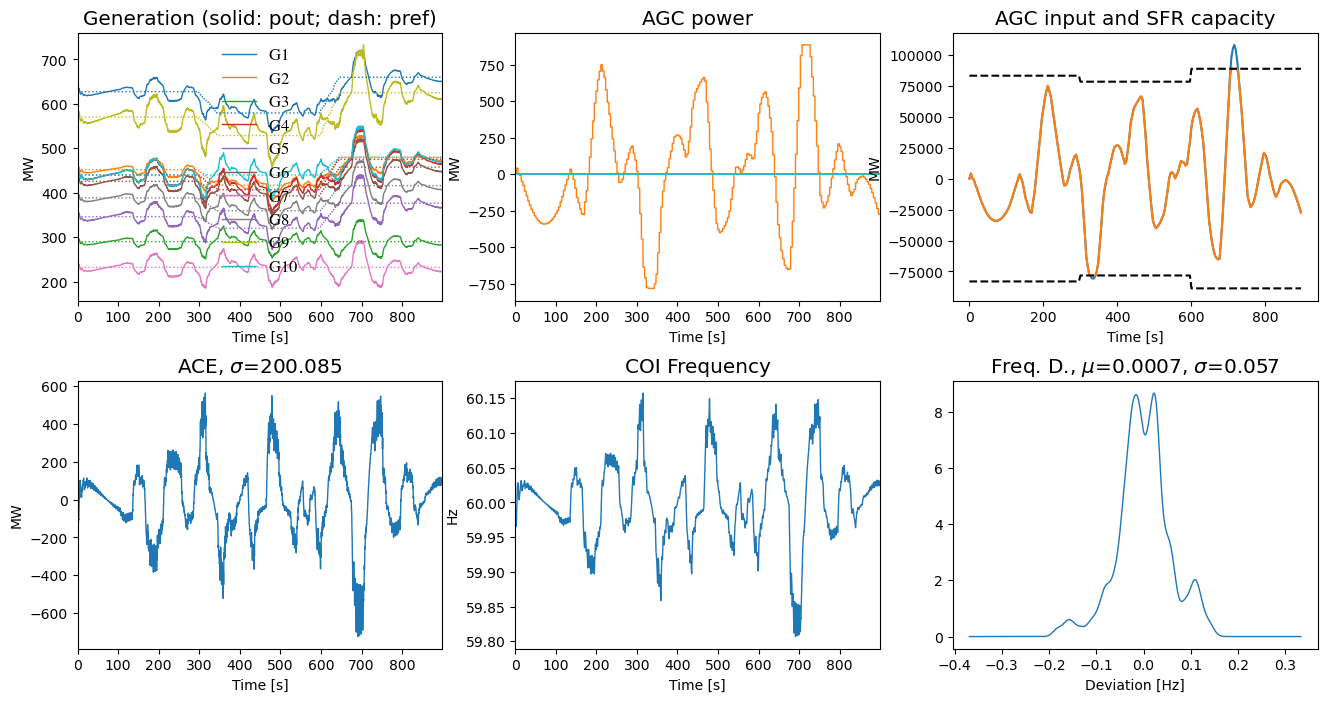

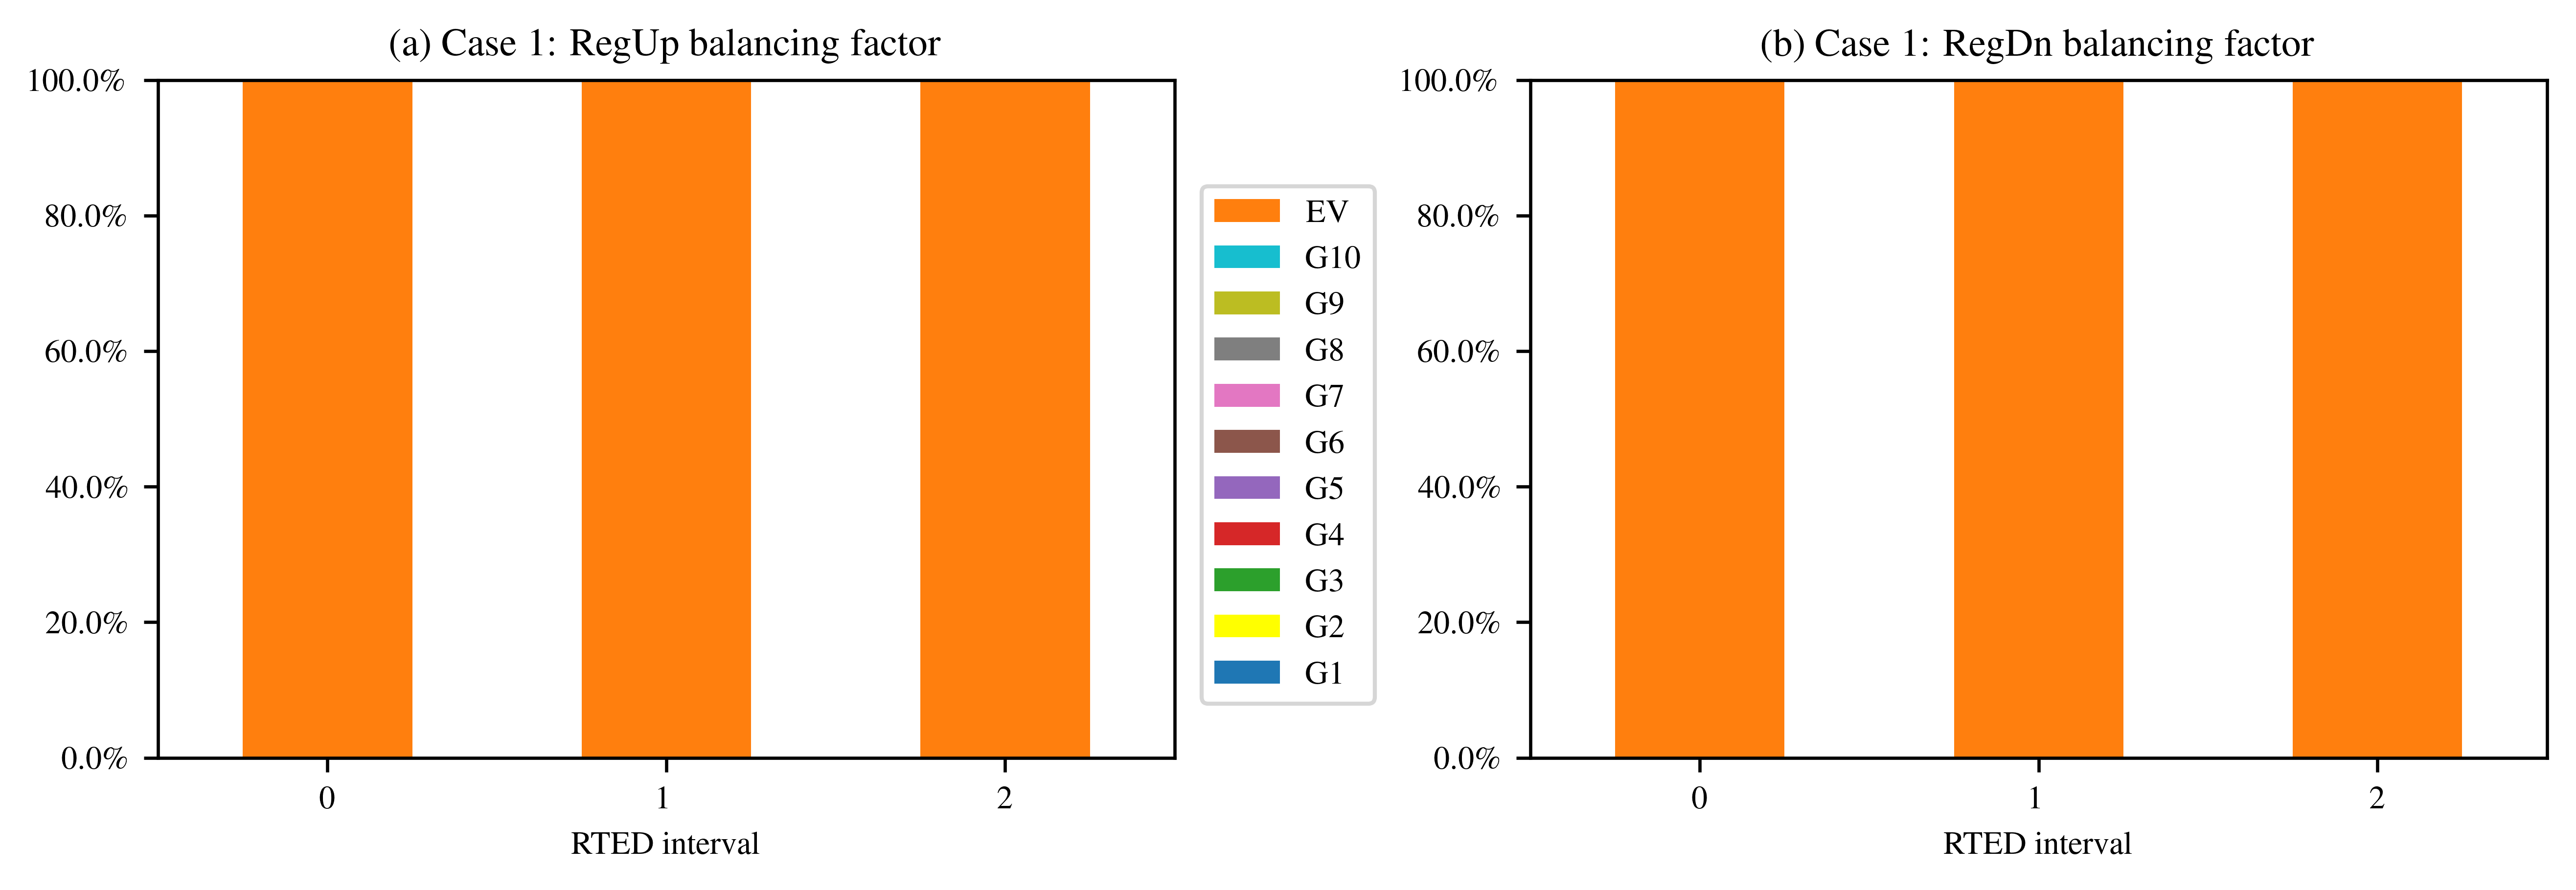

In [12]:
plt.style.use('default')

right = end_time

# data format conversion
sfr_res = pd.DataFrame(sfr_res_data, columns=['time', 'ace', 'up', 'dn', 'in'])
sfr_res['ace'] = sfr_res['ace'] * ssa.config.mva
sfr_res['up'] = sfr_res['up'] * ssa.config.mva
sfr_res['dn'] = sfr_res['dn'] * ssa.config.mva
sfr_res['in'] = sfr_res['in'] * ssa.config.mva

# data save
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                          columns=list(np.arange(0, t_total, 1)))

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.EV2.Pext, color='tab:orange',
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 fig=fig_gen, ax=ax_gen[0, 1])
ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 title=r'AGC power', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 1])

ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['ace'],
                  label='AGC raw')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['in'],
                  label='AGC input')
ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['up'],
                  label='SFR capacity',
                  linestyle='--', color='k')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['dn'],
                  linestyle='--', color='k')
ax_gen[0, 2].set_ylabel('MW')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_title('AGC input and SFR capacity')

aced = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1) * ssa.config.mva
ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ytimes=ssa.config.mva,
                 title=f'ACE, $\sigma$={aced.std().round(4)}', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ylabel='Hz',
                 ytimes=ssa.config.freq,
                 title=r'COI Frequency',
                 fig=fig_gen, ax=ax_gen[1, 1])

f_coi = pd.DataFrame()
f_coi['f'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq - ssa.config.freq
f_coi.plot(kind='kde', legend=False, linewidth=1,
           fig=fig_gen, ax=ax_gen[1, 2],
           title=f'Freq. D., $\mu$={f_coi.f.mean().round(4)}, $\sigma$={f_coi.f.std().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [Hz]', ylabel='')

# --- plot bu, bd ---
# --- collect data ---
irry = np.array(-1 * np.ones((n_ed, ssd.gen.shape[0])))
bu = irry.copy()
bd = irry.copy()
pg = irry.copy()
for rted_idx in rted_res.keys():
    bu[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bu'].values
    bd[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bd'].values
    pg[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['pg'].values
col = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['gen']
bu_df = pd.DataFrame(bu, columns=col)
bd_df = pd.DataFrame(bd, columns=col)
pg_df = pd.DataFrame(pg, columns=col)

import matplotlib.font_manager
plt.style.use('ieee')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.35, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])
#     ax.set_xticklabels([i for i in range(1, n_ed, 1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case 1: RegUp balancing factor')
axes[1].set_title('(b) Case 1: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

# --- generation cost ---
gtc = 0
for i in pg_df.index:
    c = ssd.cost.c2.values * np.power(pg_df.loc[i].values, 2) \
        + ssd.cost.c1.values * pg_df.loc[i].values \
        + ssd.cost.c1.values
    gtc += np.sum(c)

agc_out.fillna(0, inplace=True)
agc_out_sort = pd.merge(left=agc_out.rename(columns={'stg_idx':'idx'}),
                        right=ssd.cost[['idx']], on='idx', how='right')
agc_mile = pd.DataFrame(columns=list(np.arange(intv_agc, t_total, intv_agc)))
for col_id in np.arange(intv_agc, t_total, intv_agc):
    agc_mile[col_id] = np.abs(agc_out_sort[col_id] - agc_out_sort[int(col_id-intv_agc)])
agc_mile[agc_mile.columns] *= 100

# --- SFR mileage cost ---
ftc = 0
for i in agc_mile.columns:
    c = ssd.cost.c1.abs().values * agc_mile[i].values
    ftc += np.sum(c)

print(f"Total cost={np.round(gtc+ftc, 2)}")

# --- save data ---
cosim_out = pd.DataFrame()
cosim_out['Time'] = ssa.dae.ts.t
# alter the sign of ACE
cosim_out['ACE'] = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy() * ssa.config.mva * -1
cosim_out['freq'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
pout9 = ssa.dae.ts.y[:, ssa.TGOV1N.pout.a[2]].reshape(-1)
pref9 = ssa.dae.ts.y[:, ssa.TGOV1N.pref.a[2]].reshape(-1)
cosim_out['paux9'] = ssa.config.mva * (pout9-pref9)


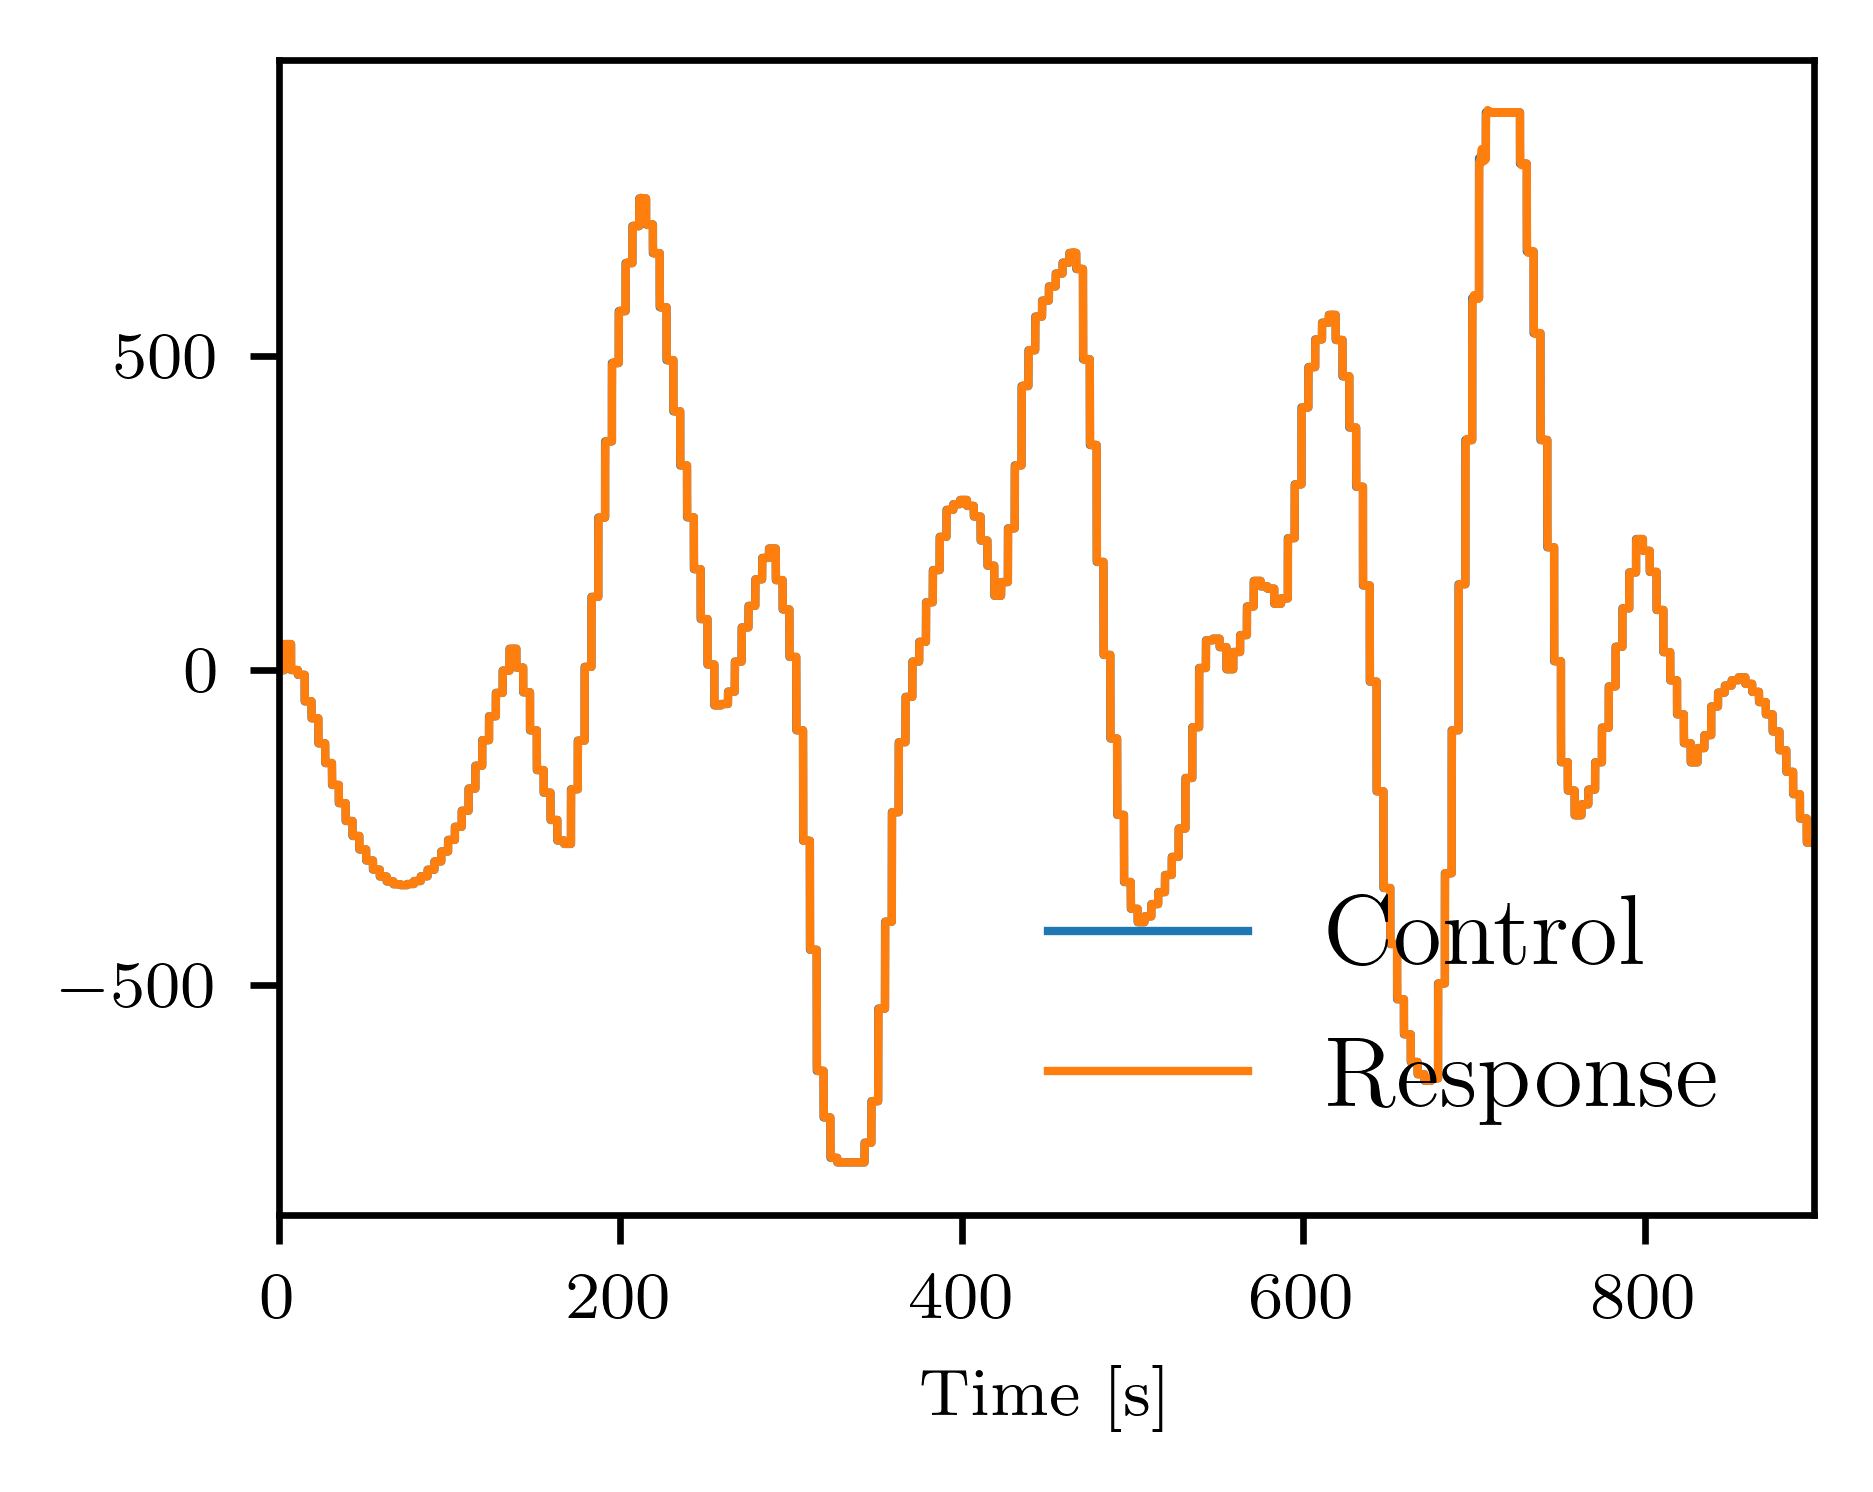

(<Figure size 1980x1500 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [13]:
# data
iev = ssa.dae.ts.x[:, ssa.EV2.Ipout_y.a]
vev = ssa.dae.ts.y[:, ssa.EV2.v.a]
pev = iev * vev
prefev = ssa.dae.ts.y[:, ssa.EV2.Pref.a]
pauxev = (pev - prefev) * ssa.config.mva

# plot
fig_e, ax_e = plt.subplots(1, 1)
ssa.TDS.plt.plot(ssa.EV2.Pext,
                 ytimes=ssa.config.mva,
                 ax=ax_e, fig=fig_e, show=False,
                 yheader=['Control'], color='tab:blue')
ssa.TDS.plt.plot_data(ssa.dae.ts.t, pauxev,
                      yheader=['Response'], color='tab:orange',
                      ax=ax_e, fig=fig_e)

In [14]:
# cosim_out.to_csv('cosim_18_S_out.csv', index=False)
# sse_out.to_csv('cosim_18_S_sse.csv', index=False)
# bu_df.to_csv('cosim_18_S_bu.csv', index=False)
# bd_df.to_csv('cosim_18_S_bd.csv', index=False)
# pg_df.to_csv('cosim_18_S_pg.csv', index=False)
# agc_mile.to_csv('cosim_18_S_agcm.csv', index=False)
# sfr_res.to_csv('cosim_18_S_sfr.csv', index=False)
# ev_agc.to_csv('cosim_18_S_evagc.csv', index=False)
# ev_soc.to_csv('cosim_18_S_evsoc.csv', index=False)
# sse.ev.to_csv('cosim_18_S_evdata.csv', index=False)

# import csv
# new_path = open('cosim_18_S_rted.csv', 'w')
# z = csv.writer(new_path)
# for new_k, new_v in rted_res.items():
#     z.writerow([new_k, new_v])
# new_path.close()